In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize(64),  # DCGAN typically uses 64x64 images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Z-score normalization
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # Import MNIST dataset
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers = 2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.53MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.21MB/s]


In [ ]:
# Weight initialization as specified in DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 1024, 4, 1, 0, bias=False), # Bias false because we use batch normalization
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),  # 1 channel for MNIST
            nn.Tanh()
            )

    def forward(self, z):
            return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),  # 1 channel for MNIST
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # Outputs probability between 0 and 1
            )

    def forward(self, x):
        return self.net(x).view(-1, 1).squeeze(1)

In [ ]:
def show_generated_images(images):
    images = images.view(-1, 1, 64, 64)
    images = images.cpu().data
    grid = torch.cat([img for img in images[:16]], dim=2).squeeze()
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 100
generator = Generator(noise_dim).to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

loss_fn = nn.BCELoss() # Loss from the paper is similar to BCE
lr = 0.0002

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

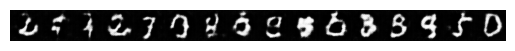

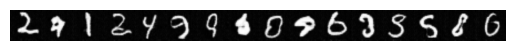

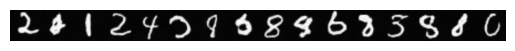

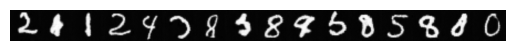

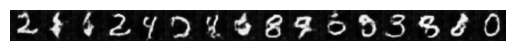

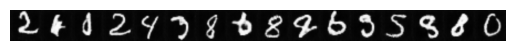

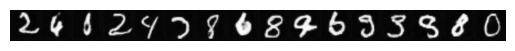

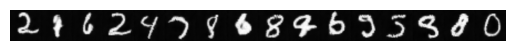

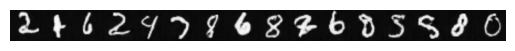

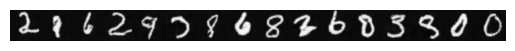

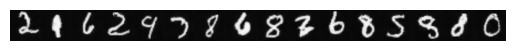

In [ ]:
epochs = 100
fixed_noise = torch.randn(16, noise_dim, 1, 1, device=device) # This allows us to see how the generator improves over time with the same input

real_label = 1.0
fake_label = 0.0

for epoch in range(epochs):
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
    for i, (real_imgs, _) in enumerate(loop):
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # Train discriminator on real images
        discriminator.zero_grad()
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        outputs = discriminator(real_imgs)
        d_loss_real = loss_fn(outputs, label) # How well it identifies real images
        d_loss_real.backward()

        # Train discriminator on fake images
        z = torch.randn(batch_size, noise_dim, 1, 1, device=device) # Generate new fake images
        fake_imgs = generator(z)
        label.fill_(fake_label)
        outputs = discriminator(fake_imgs.detach())
        d_loss_fake = loss_fn(outputs, label)
        d_loss_fake.backward()
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step()

        generator.zero_grad()
        label.fill_(real_label)
        outputs = discriminator(fake_imgs)
        g_loss = loss_fn(outputs, label)
        g_loss.backward()
        optimizer_G.step()


        loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())
    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad() :
            fake_imgs = generator(fixed_noise)
            show_generated_images(fake_imgs)